In [1]:
import numpy as np
import pandas as pd
import os
import sys
import torch
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import optuna
import random
import joblib
from config import RESULTS_DIR, IMAGES_DIR, DATA_DIR, DATASET_PATH, MOTIF_INDEXES_PATH, K, N, P, NORMALIZE_FLAGS

print(f"Results will be saved in: {RESULTS_DIR}")
print(f"Images will be saved in: {IMAGES_DIR}")
print(f"Data will be accessed from: {DATA_DIR}")

os.makedirs(RESULTS_DIR, exist_ok=True)

if '__file__' in globals():
    # For standalone scripts
    base_dir = os.path.dirname(__file__)
else:
    # For Jupyter or interactive environments
    base_dir = os.getcwd()

# Add the parent directory of `utils` to the Python path
sys.path.append(os.path.abspath(os.path.join(base_dir, "../")))

2025-01-22 18:49:04,202 - INFO - Results will be saved in: /home/mgsilva/motifpred/results/syntheticdata1/variables=[0,2]
2025-01-22 18:49:04,202 - INFO - Images will be saved in: /home/mgsilva/motifpred/images/syntheticdata1/variables=[0,2]
2025-01-22 18:49:04,203 - INFO - Data will be accessed from: /home/mgsilva/motifpred/data/syntheticdata1/variables=[0,2]


Results will be saved in: /home/mgsilva/motifpred/results/syntheticdata1/variables=[0,2]
Images will be saved in: /home/mgsilva/motifpred/images/syntheticdata1/variables=[0,2]
Data will be accessed from: /home/mgsilva/motifpred/data/syntheticdata1/variables=[0,2]


In [2]:
data = np.genfromtxt(DATASET_PATH, delimiter=",").astype(int).reshape((K, N))
motif_indexes = np.genfromtxt(MOTIF_INDEXES_PATH, delimiter=",").astype(int)

print(motif_indexes)

[    0    10    22 ... 99922 99956 99992]


In [3]:
# Import shared setup
from utils.setup import seed, device, early_stopper, pipeline, test_tensor

# Example usage
print(f"Device: {device}")
test_tensor()

Device: cuda
tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691],
        [0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938],
        [0.6128, 0.1519, 0.0453]])


TRAIN: [    0     1     2 ... 15997 15998 15999] TEST: [16000 16001 16002 ... 19997 19998 19999]
TRAIN: [20000 20001 20002 ... 35997 35998 35999] TEST: [36000 36001 36002 ... 39997 39998 39999]
TRAIN: [40000 40001 40002 ... 55997 55998 55999] TEST: [56000 56001 56002 ... 59997 59998 59999]
TRAIN: [60000 60001 60002 ... 75997 75998 75999] TEST: [76000 76001 76002 ... 79997 79998 79999]
TRAIN: [80000 80001 80002 ... 95997 95998 95999] TEST: [96000 96001 96002 ... 99997 99998 99999]


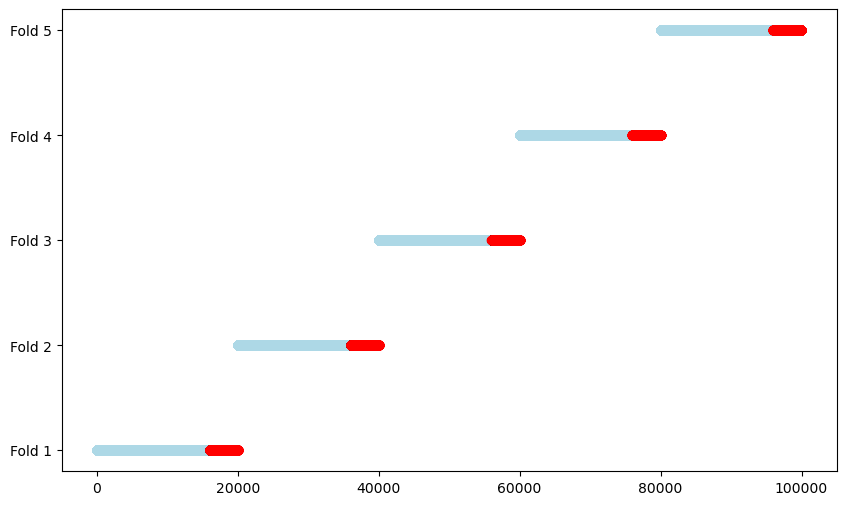

In [4]:
from utils.timeseries_split import BlockingTimeSeriesSplit

#create index  
indexes = np.arange(len(data[0]))

#split data
tscv = BlockingTimeSeriesSplit(n_splits=5)
# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))
for i, (train_index, test_index) in enumerate(tscv.split(indexes)):
    # Plot train and test indices
    ax.plot(train_index, np.zeros_like(train_index) + i, 'o', color='lightblue')
    ax.plot(test_index, np.zeros_like(test_index) + i, 'o', color='red')
    print("TRAIN:", train_index, "TEST:", test_index)
    

ax.set_yticks(np.arange(5), ["Fold {}".format(i) for i in range(1, 6)])
plt.show()

In [5]:
from utils.utils import create_dataset

lookback_period = 100 #window size
step = 5 #step size for the sliding window
forecast_period = 50 #forward window size

#X_series: past window, X_indices: indexes of the motif in the window,  y: next relative index of the motif
X_series, X_indices, y = create_dataset(data, lookback_period, step, forecast_period, motif_indexes)

#X_series is (num_samples, lookback_period, num_features)
X_mask = np.zeros((X_series.shape[0], X_series.shape[1])) 

for i, obs_motif_indexes in enumerate(X_indices):
    for j, idx in enumerate(obs_motif_indexes):
        idx = int(idx)
        X_mask[i, idx:idx+P] = 1

X_mask = torch.tensor(X_mask, dtype=torch.float32)

# X_series, X2, and y are now PyTorch tensors
print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, lookback_period, num_features)
print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, lookback_period)
print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
print("y shape:", y.shape)    # Expected shape: (num_samples, 1)


X_series shape: torch.Size([19979, 100, 3])
X_mask shape: torch.Size([19979, 100])
X_indices shape: torch.Size([19979, 6, 1])
y shape: torch.Size([19979, 1])


In [10]:
from models.ffnn_pytorch import FFNN
from models.lstm_pytorch import LSTM
from models.cnn_pytorch import CNN
from models.tcn_pytorch import TemporalConvNet
from models.transformer_pytorch import TimeSeriesTransformer
from models.baseline_pytorch import BaselineAverage, BaselineLastDifference
from utils.utils import print_study_results, get_best_model_results, plot_best_model_results, plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config

models = ["FFNN", "LSTM", "CNN", "Transformer", "Baseline"]
inputs = ["Series", "Series_Masking", "Indexes"]

n_trials = 100
num_epochs = 500


def process_baseline_model(model_class, input_name, X, normalize_flags, n_trials, num_epochs, pipeline, seed, y):
    """Process baseline models."""
    model_name = f"{model_class.__name__}{input_name}"
    dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")

    if os.path.exists(os.path.join(dir, "best_model_results.csv")):
        print(f"Model {model_name} already exists")
        return

    study = joblib.load(os.path.join(dir, "study.pkl"))
    fold_val_losses, fold_test_losses = get_best_model_results(study)

    (epochs_train_losses, epochs_val_losses, val_losses, test_losses,
     test_mae_per_fold, test_rmse_per_fold, all_predictions, all_true_values) = get_preds_best_config(
        study, pipeline, model_class, "Baseline", [], num_epochs=num_epochs, seed=seed, X=X, y=y, normalize_flags=normalize_flags
    )

    if not np.allclose(fold_val_losses, val_losses):
        raise Exception("Best model val losses are not close to val losses")

    # Save results to CSV
    results = pd.DataFrame({
        "fold": np.arange(1, 6),
        "val_loss": fold_val_losses,
        "test_loss": fold_test_losses,
        "test_mae": test_mae_per_fold,
        "test_rmse": test_rmse_per_fold
    })
    results.to_csv(os.path.join(dir, "best_model_results.csv"), index=False, mode='w')


def process_non_baseline_model(model_type, model_params_keys, input_name, X, normalize_flags, num_epochs, seed, pipeline, y):
    """Process non-baseline models."""
    model_name = f"{model_type}{input_name}"
    model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")

    if os.path.exists(os.path.join(model_results_dir, "best_model_results.csv")):
        print(f"Model {model_name} already exists")
        return

    study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
    fold_val_losses, fold_test_losses = get_best_model_results(study)

    (epochs_train_losses, epochs_val_losses, val_losses, test_losses,
     test_mae_per_fold, test_rmse_per_fold, all_predictions, all_true_values) = get_preds_best_config(
        study, pipeline, eval(model_type), model_type, model_params_keys, num_epochs=num_epochs, seed=seed, X=X, y=y, normalize_flags=normalize_flags
    )

    if not np.allclose(fold_val_losses, val_losses):
        raise Exception("Best model val losses are not close to val losses")

    # Save results to CSV
    results = pd.DataFrame({
        "fold": np.arange(1, 6),
        "val_loss": fold_val_losses,
        "test_loss": fold_test_losses,
        "test_mae": test_mae_per_fold,
        "test_rmse": test_rmse_per_fold
    })
    results.to_csv(os.path.join(model_results_dir, "best_model_results.csv"), index=False, mode='w')


for model_type in models:
    for input_name in inputs:
        normalize_flags = NORMALIZE_FLAGS
        n_trials, num_epochs = (1, 1) if model_type == "Baseline" else (n_trials, num_epochs)

        if model_type == "Baseline":
            if input_name != "Indexes":
                continue

            X = {"X_series": X_series, "X_mask": X_mask, "X_indices": X_indices}
            normalize_flags = {"X_series": True, "X_mask": False, "X_indices": False}

            for model_class in [BaselineAverage, BaselineLastDifference]:
                process_baseline_model(
                    model_class, input_name, X, normalize_flags, n_trials, num_epochs, pipeline, seed, y
                )

        else:
            if input_name == "Series":
                X = {"X_series": X_series}
            elif input_name == "Series_Masking":
                X = {"X_series": X_series, "X_mask": X_mask}
            else:
                X = {"X_indices": X_indices}

            model_params_map = {
                "FFNN": ["hidden_sizes_list"],
                "LSTM": ["hidden_sizes_list"],
                "CNN": ["kernel_size", "num_filters_list", "pool_size"],
                "TCN": ["kernel_size", "num_channels_list", "dropout"],
                "Transformer": ["d_model", "n_heads", "e_layers", "dim_feedforward", "dropout"]
            }

            process_non_baseline_model(
                model_type, model_params_map[model_type], input_name, X, normalize_flags, num_epochs, seed, pipeline, y
            )


Model FFNNSeries already exists
Model FFNNSeries_Masking already exists
Model FFNNIndexes already exists
Model LSTMSeries already exists
Model LSTMSeries_Masking already exists
Model LSTMIndexes already exists
Model CNNSeries already exists
Model CNNSeries_Masking already exists
Model CNNIndexes already exists
Model TransformerSeries already exists
Model TransformerSeries_Masking already exists
Model TransformerIndexes already exists
Model BaselineAverageIndexes already exists
Best hyperparameters: {'batch_size': 128}


Validation Losses: [inf, inf, inf, inf, inf]
Mean validation loss: inf
Test Losses: [56.83980178833008, 56.90613555908203, 56.74718475341797, 56.862327575683594, 56.748435974121094]
Mean test loss: 56.820777130126956
Test MAE: [4.359199047088623, 4.372966289520264, 4.356696128845215, 4.3717145919799805, 4.355444431304932]


In [16]:
import numpy as np
from scipy import stats
rng = np.random.default_rng()
from scipy.stats import ttest_rel

models = ["FFNN", "LSTM", "CNN", "Transformer", "Baseline"]
inputs = ["Series", "Series_Masking", "Indexes"]

results_df = pd.DataFrame(columns=["model", "input", "fold", "mae", "rmse"])

# Combine each model with each input
for model_type in models:
    for input_name in inputs:
        # Handle baseline-specific logic
        if model_type == "Baseline":
            n_trials, num_epochs = (1, 1)
            if input_name != "Indexes":
                continue
            
            # Process both BaselineAverage and BaselineLastDifference
            baseline_variants = ["BaselineAverage", "BaselineLastDifference"]
            for baseline_type in baseline_variants:
                model_name = f"{baseline_type}{input_name}"
                print(f"Processing Model: {model_name}")

                # Construct the results directory path
                model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
                results_file = os.path.join(model_results_dir, "best_model_results.csv")

                # Skip if results file doesn't exist
                if not os.path.exists(results_file):
                    print(f"Results file for {model_name} not found. Skipping.")
                    continue

                # Load results from CSV
                results = pd.read_csv(results_file)
                maes = results["test_mae"].values
                rmses = results["test_rmse"].values

                # Add results to the dataframe
                for i in range(len(maes)):  # Assuming results have folds
                    results_df = pd.concat([
                        results_df,
                        pd.DataFrame([{
                            "model": baseline_type,
                            "input": input_name,
                            "fold": i + 1,
                            "mae": maes[i],
                            "rmse": rmses[i]
                        }])
                    ], ignore_index=True)

        else:
            n_trials = 100
            num_epochs = 500

            model_name = f"{model_type}{input_name}"
            print(f"Processing Model: {model_name}")

            # Construct the results directory path
            model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
            results_file = os.path.join(model_results_dir, "best_model_results.csv")

            # Skip if results file doesn't exist
            if not os.path.exists(results_file):
                print(f"Results file for {model_name} not found. Skipping.")
                continue

            # Load results from CSV
            results = pd.read_csv(results_file)
            maes = results["test_mae"].values
            rmses = results["test_rmse"].values

            # Add results to the dataframe
            for i in range(len(maes)):  # Assuming results have folds
                results_df = pd.concat([
                    results_df,
                    pd.DataFrame([{
                        "model": model_type,
                        "input": input_name,
                        "fold": i + 1,
                        "mae": maes[i],
                        "rmse": rmses[i]
                    }])
                ], ignore_index=True)

# Display the results
print(results_df)

Processing Model: FFNNSeries
Processing Model: FFNNSeries_Masking
Processing Model: FFNNIndexes
Processing Model: LSTMSeries
Processing Model: LSTMSeries_Masking
Processing Model: LSTMIndexes
Processing Model: CNNSeries
Processing Model: CNNSeries_Masking
Processing Model: CNNIndexes
Processing Model: TransformerSeries
Processing Model: TransformerSeries_Masking
Processing Model: TransformerIndexes
Processing Model: BaselineAverageIndexes
Processing Model: BaselineLastDifferenceIndexes
                     model    input fold       mae       rmse
0                     FFNN   Series    1  9.389045  11.669245
1                     FFNN   Series    2  8.793365  10.960507
2                     FFNN   Series    3  9.180077  11.325398
3                     FFNN   Series    4  8.737524  11.029864
4                     FFNN   Series    5  8.585275  10.890684
..                     ...      ...  ...       ...        ...
65  BaselineLastDifference  Indexes    1  4.359199   7.539217
66  BaselineL

/tmp/ipykernel_46996/2257731230.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([
